In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# df = pd.read_csv('exp1_res.csv').drop_duplicates()
# df = pd.read_csv('exper7_results_celu.csv').drop_duplicates()
# df = pd.read_csv('exper6_results_lrelu.csv').drop_duplicates()
# df = pd.read_csv('exper8_results_celu.csv').drop_duplicates()
df = pd.read_csv('exper5_results_relu.csv').drop_duplicates()

In [4]:
emasks = []
masks = []
for msk in df.Mask.unique():
    if msk[:2] == 'e_':
        emasks.append(msk)
    elif msk != 'eue':
        masks.append(msk)
print(masks)
print(emasks)

['basic_bern', 'decorrelating_sc', 'dpp', 'k_dpp', 'k_dpp_noisereg']
['e_basic_bern', 'e_decorrelating_sc', 'e_dpp', 'e_k_dpp', 'e_k_dpp_noisereg']


In [5]:
# http://abelsiqueira.github.io/blog/introduction-to-performance-profile/

In [6]:
dsets = []
for fname in df.fname:
    dsets.append(fname.split('_')[0])
df['dset'] = dsets

In [8]:
# %%time
large_data = []
metric = 'Acc'
for fname, df_temp in df.groupby('fname'):
    data = []
    assert len(df_temp[df_temp.Mask == 'eue']) == 1
    eue_performance = df_temp[df_temp.Mask == 'eue'][metric].values[0]
    dct_single = {'eue': eue_performance}
    for mask in masks[:-1]:
        perf = df_temp[df_temp.Mask == mask][metric].values[0]
        dct_single[mask] = perf
    dct_single = {k: 1./v for k, v in dct_single.items()}
    data.append(dct_single)
    
    df_res = pd.DataFrame(data)
    normalized_values = df_res.values/df_res.min(axis = 1).values[:,None]
    df_res = pd.DataFrame(normalized_values, columns = df_res.columns)
    large_data.append(df_res)

In [9]:
df_res = pd.concat(large_data)

In [10]:
df_res.columns

Index(['basic_bern', 'decorrelating_sc', 'dpp', 'eue', 'k_dpp'], dtype='object')

In [11]:
def make_dm_plot(df_res, masks, emasks,
                 metric = 'some metric', 
                 exper = 'some exper',
                 taus = np.linspace(1, 3, 101),
                 plotter = plt.plot,
                 **kwargs
                ):
    npp = len(df_res)
    for msk in masks:
        if 'eue' == msk:
            continue
        pas = []
        for tau in taus:
            pas.append(sum(df_res[msk].values <= tau)/npp)
        print(f'{msk}, {pas[0]:.2f}')
        plotter(taus, pas, label = msk,**kwargs)
    for msk in emasks:
        if 'eue' == msk:
            continue
        pas = []
        for tau in taus:
            pas.append(sum(df_res[msk].values <= tau)/npp)
        print(f'{msk}, {pas[0]:.2f}')
        plotter(taus, pas, label = msk,**kwargs)
    pas = []
    for tau in taus:
        pas.append(sum(df_res['eue'].values <= tau)/npp)
    print(f'{msk}, {pas[0]:.2f}')
    plotter(taus, pas, 'k', label = 'eue',**kwargs)

    plt.legend()
    plt.title(metric + '|' + exper)

basic_bern, 0.14
decorrelating_sc, 0.23
dpp, 0.26
k_dpp, 0.32
eue, 0.37


(1, 3)

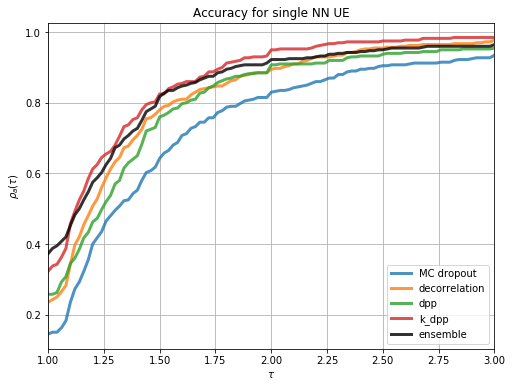

In [12]:
plt.figure(figsize=(8,6))
masks = ['basic_bern', 'decorrelating_sc', 'dpp', 'k_dpp', 
         'eue']
emasks = []
# emasks = ['e_basic_bern', 'e_decorrelating_sc', 'e_l_dpp', 'e_rank_l_dpp', 'eue']
make_dm_plot(df_res[masks], masks, emasks, metric, f' ', 
             taus = np.linspace(1, 3, 101),lw=3, alpha=.8)
plt.grid()
plt.title('Accuracy for single NN UE')
plt.legend(['MC dropout',
            'decorrelation',
            'dpp', 'k_dpp', 'ensemble'
           ])
plt.xlabel(r'$\tau$')
plt.ylabel(r'$\rho_a(\tau$)')
plt.xlim(1, 3)
# plt.label(r'$\tau$')
# plt.savefig('./images/dolan_acc_single.png', dpi = 600)


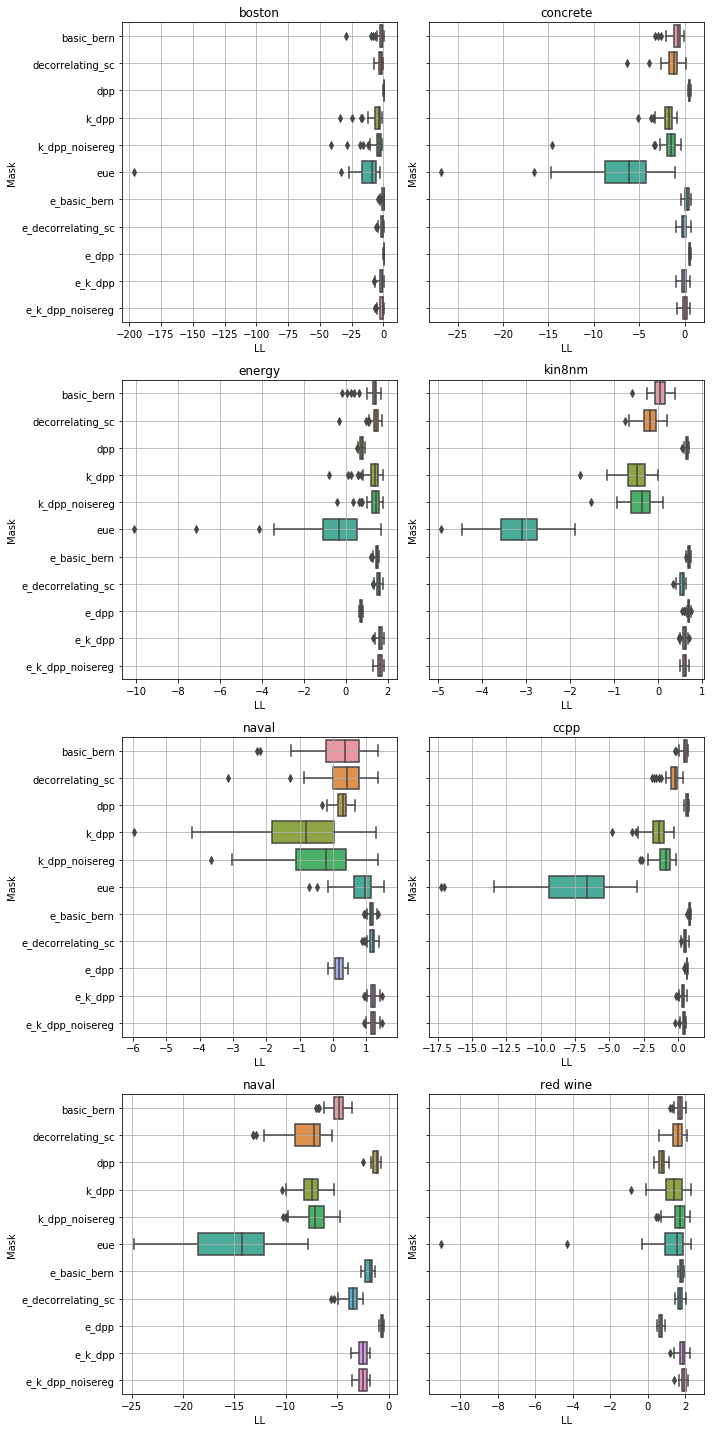

In [13]:
import seaborn as sns
cnt = 1
names_as_in_paper = [
    'boston', 'concrete', 'energy', 'kin8nm',
    'naval', 'ccpp', 'naval', 'red wine', 'yacht'
]


plt.figure(figsize=(10,20))
for dset in df.dset.unique():
    plt.subplot(4,2,cnt)
    dfx = df[(df.dset == dset)]
    g=sns.boxplot(x = 'LL', y = 'Mask', data = dfx)#, hue = 'dset')
    if cnt % 2 == 0:
        g.set(yticklabels=[])
    plt.grid()
    plt.title(names_as_in_paper[cnt-1])
    cnt += 1
plt.tight_layout()


bost
conc
ener
kin8
nava
ccpp
red
yach


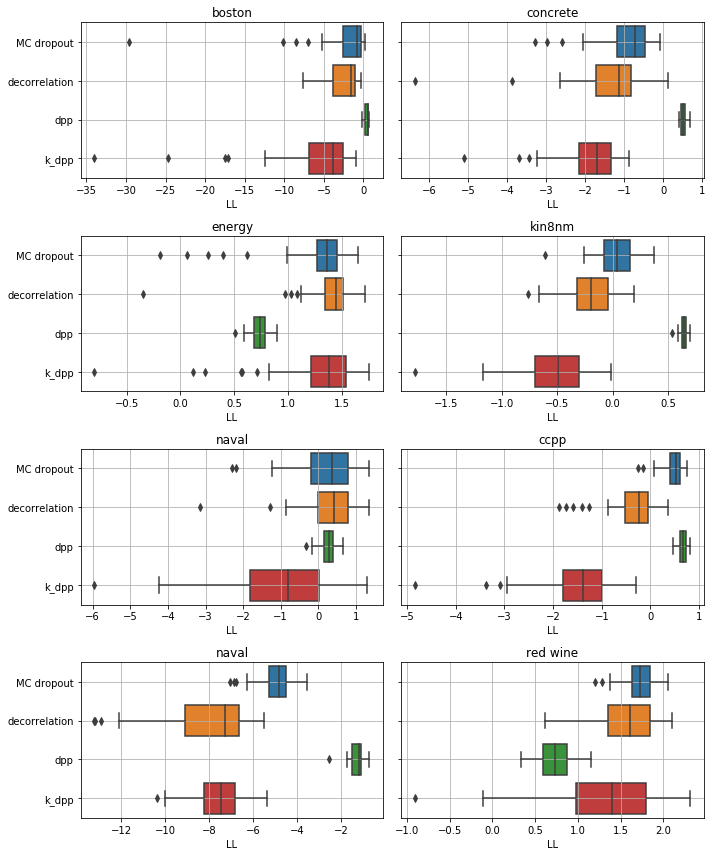

In [14]:
# sns.boxplot(x="day", y="total_bill", hue="smoker",
#                  data=tips, palette="Set3")
import seaborn as sns
cnt = 1
names_as_in_paper = [
    'boston', 'concrete', 'energy', 'kin8nm',
    'naval', 'ccpp', 'naval', 'red wine', 'yacht'
]

# masks1 = ['basic_bern', 'decorrelating_sc', 'l_dpp', 
#           'l_dpp_htnorm', 'l_dpp_noisereg', 'rank_l_dpp']

plt.figure(figsize=(10,12))
for dset in df.dset.unique():
    plt.subplot(4,2,cnt)
    dfx = df[(df.dset == dset) & (df.Mask.isin(masks[:-1]))]
    g=sns.boxplot(x = 'LL', y = 'Mask', data = dfx)#, hue = 'dset')
    print(dset)
    g.set(ylabel='')
    if cnt % 2 == 0:
        g.set(yticklabels=[])
        
    else:
        g.set(yticklabels=['MC dropout', 'decorrelation',
                           'dpp', 'k_dpp', 'k_dpp_noisereg',
                          ])
    plt.grid()
    plt.title(names_as_in_paper[cnt-1])
    cnt += 1
plt.tight_layout()
plt.savefig('./images/LL_UCI_single.png', dpi = 600)

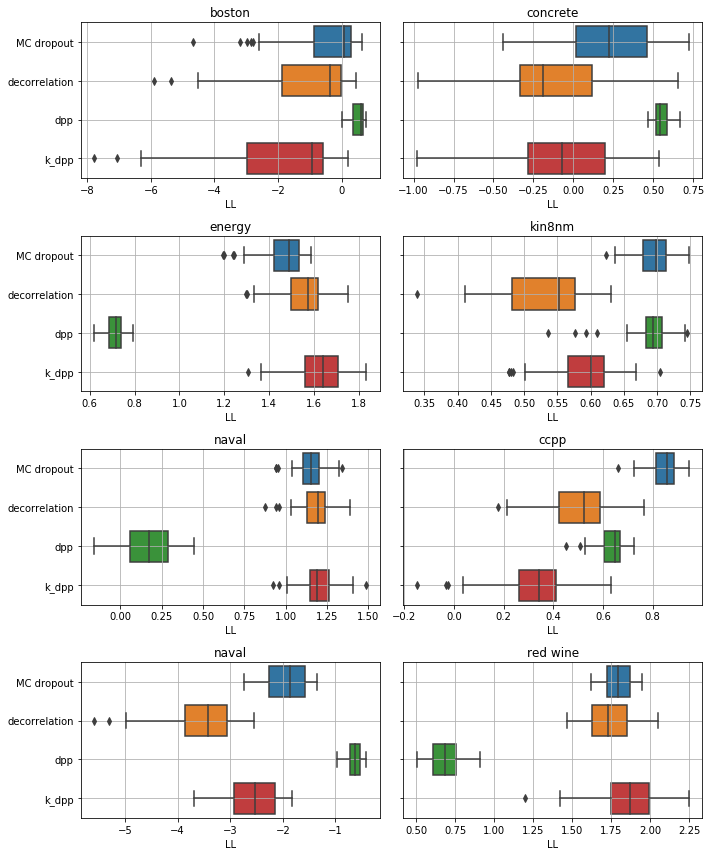

In [39]:
# sns.boxplot(x="day", y="total_bill", hue="smoker",
#                  data=tips, palette="Set3")
import seaborn as sns
cnt = 1
names_as_in_paper = [
    'boston', 'concrete', 'energy', 'kin8nm',
    'naval', 'ccpp', 'naval', 'red wine', 'yacht'
]

# masks1 = ['basic_bern', 'decorrelating_sc', 'l_dpp', 
#           'l_dpp_htnorm', 'l_dpp_noisereg', 'rank_l_dpp']

plt.figure(figsize=(10,12))
for dset in df.dset.unique():
    plt.subplot(4,2,cnt)
    dfx = df[(df.dset == dset) & (df.Mask.isin(emasks[:-1]))]
    g=sns.boxplot(x = 'LL', y = 'Mask', data = dfx)#, hue = 'dset')
    g.set(ylabel='')
    if cnt % 2 == 0:
        g.set(yticklabels=[])
    else:
        g.set(yticklabels=['MC dropout', 'decorrelation',
                           'dpp', 'k_dpp',
                           'k_dpp_noisereg'
                          ])
    plt.grid()
    plt.title(names_as_in_paper[cnt-1])
    cnt += 1
plt.tight_layout()
plt.savefig('./images/LL_UCI_ens.png', dpi = 600)